In [2]:
import pandas as pd
import glob
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
matplotlib.use('TkAgg')
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
##define nlp and start cleaning data
nlp= spacy.load("en")

# List of stop words to equalize data
stop_list = []

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [4]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [5]:
# Merging csv files (without repeating header)
interesting_files = glob.glob("*.csv") 
df = pd.concat((pd.read_csv(f, header = 0) for f in interesting_files))
df

,Subreddit,Date,Author,Title,Body,URL
0,Depression,1583020847,jamie11w,Got referred to volunteers,Uk CAHMS service is shit. I’m sure I have schi...,/r/depression/comments/fblivc/got_referred_to_...
1,Depression,1583020904,NoDeedUnpunished,Any luck with holistic solutions?,Has anybody had any luck with holistic treatme...,/r/depression/comments/fbljcl/any_luck_with_ho...
2,Depression,1583021169,Fancy_Pens,Slept the day away again,Didn’t leave bed until 4:20pm so I could go to...,/r/depression/comments/fbllbk/slept_the_day_aw...
3,Depression,1583021314,creeklisa,getting deeper and deeper,"I want help, I can't say to the people that ca...",/r/depression/comments/fblmhb/getting_deeper_a...
4,Depression,1583021438,JudasofBelial,I want it to be okay for me to be unhappy.,Obviously I don't want to be unhappy. I don't ...,/r/depression/comments/fblngh/i_want_it_to_be_...
...,...,...,...,...,...,...
7149,Anxiety,1585612200,Prestoric_user,I want to sell my console but its hard,I want to sell my ps4 since i dont use it anym...,/r/Anxiety/comments/fs251x/i_want_to_sell_my_c...
7150,Anxiety,1585612297,Gametest014,Just looking for advice,So yesterday(this morning) I went to sleep at ...,/r/Anxiety/comments/fs260r/just_looking_for_ad...
7151,Anxiety,1585612474,throw-away-3005,My first bath,I took the first bath in our new house and it ...,/r/Anxiety/comments/fs27t3/my_first_bath/
7152,Anxiety,1585612576,AnxiousFishermen,Anyone else always crossing their legs?,Without meaning too i always find my self cros...,/r/Anxiety/comments/fs28s1/anyone_else_always_...


In [6]:
#create a list of documents (list of lists) 
text_doc = df['Body'].tolist()

In [7]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [8]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)

subreddit = [];
for sub in df['Subreddit']:
    a2 = sub
    subreddit.append(a2)
    
d = list(zip(empt,subreddit))
#df_doc_dep is a dataframe that has cleaned posts from the subreddits.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)

df_doc_dep = pd.DataFrame(d, columns = ['Body', 'Subreddit'])
df_doc_dep

,Body,Subreddit
0,Uk cahms service shit sure schizophrenia fucki...,Depression
1,anybody luck holistic treatment gut health met...,Depression
2,leave bed 4:20pm work 5:00pm feel like walk dr...,Depression
3,want help people care feel right like wrong bo...,Depression
4,obviously want unhappy want depressed miserabl...,Depression
...,...,...
28092,want sell ps4 use anymore want money hard pers...,Anxiety
28093,yesterday(this morning sleep midnight 12 wake ...,Anxiety
28094,bath new house cause flood basement live boyfr...,Anxiety
28095,mean find self cross leg,Anxiety


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


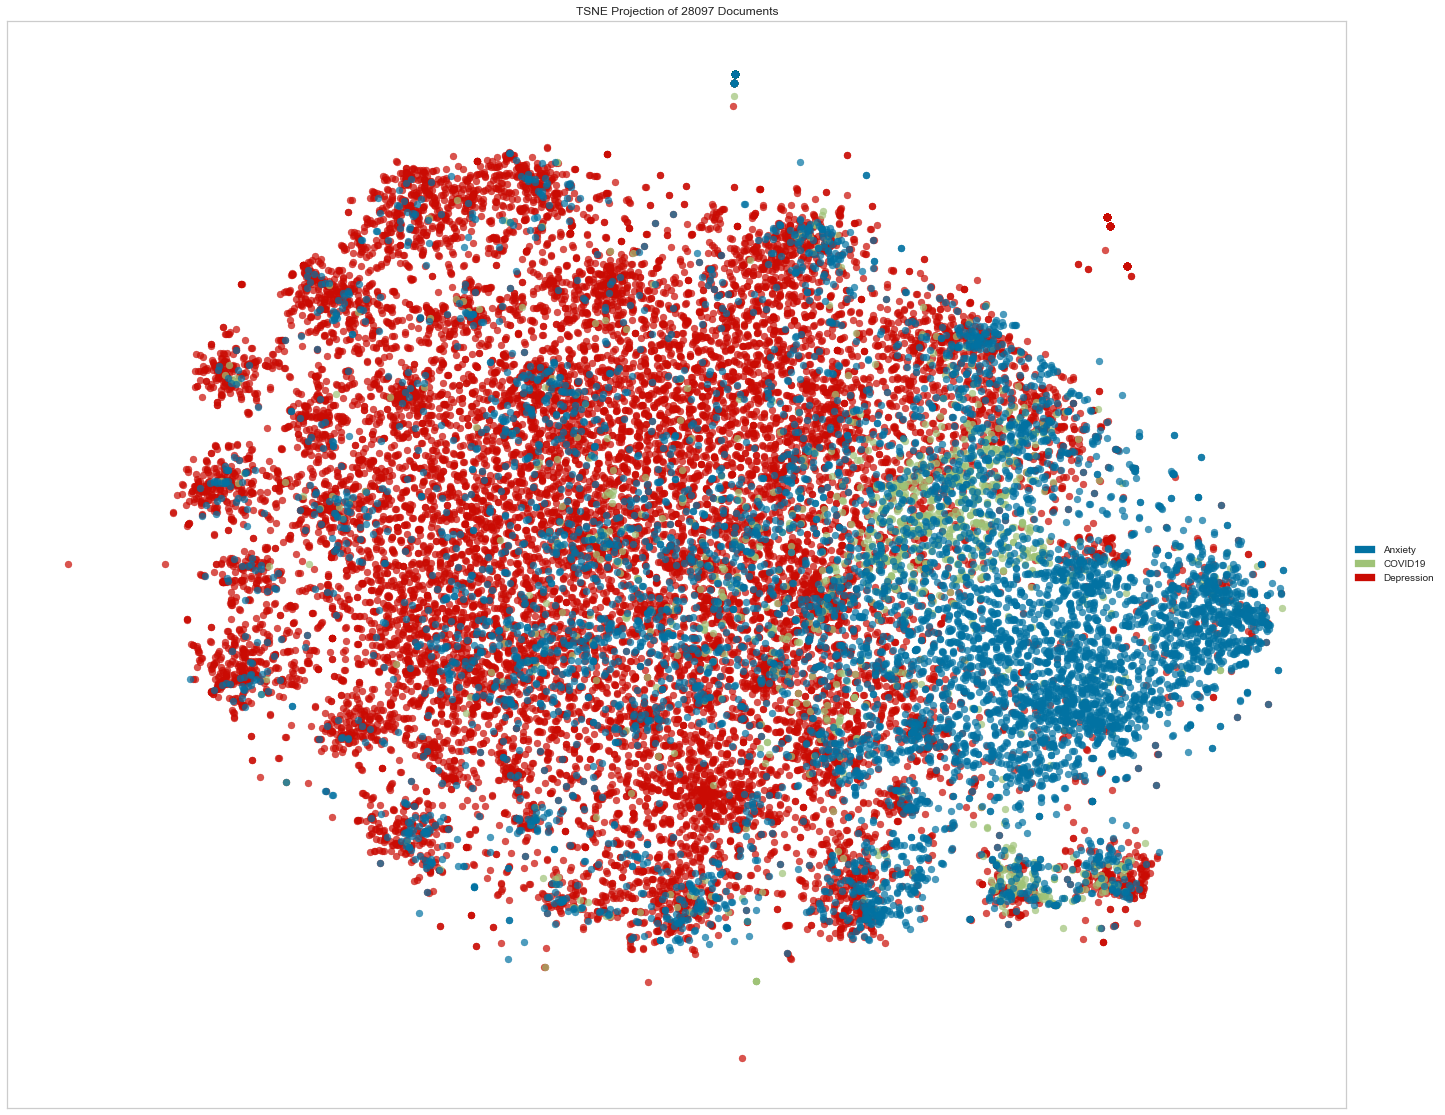

In [11]:
# from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = df_doc_dep.Body

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = df_doc_dep.Subreddit

# Create the visualizer and draw the vectors
fig, ax = plt.subplots(figsize=(30,20))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show(outpath = 't_sne_lg.jpg')

In [64]:
import gensim
import numpy as np
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import plotly.offline as plt
import plotly.graph_objs as go
plt.init_notebook_mode(connected=True)
from gensim.models import Word2Vec
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

In [13]:
model = wv

In [63]:
def get_coordinates(model, words):
    arr = np.empty((0,300), dtype='f')
    labels = []
    for wrd_score in words:
        try:
            wrd_vector = model[wrd_score]
            arr = np.append(arr, np.array([wrd_vector]), axis=0)
            labels.append(wrd_score)
        except:
            pass
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    z_coords = Y[:, 2]
    return x_coords, y_coords, z_coords

In [73]:
words = df_doc_dep.Body

x, y, z = get_coordinates(model, words)

plot = [go.Scatter3d(x = x,
                    y = y,
                    z = z,
                    mode = 'markers+text',
                    textposition='bottom center',
                    hoverinfo = 'text',
                    marker=dict(size=5,opacity=0.8))]

layout = go.Layout(title='Mental Health Subreddits')
fig = go.Figure(data=plot, layout=layout)
plt.iplot(fig)



AttributeError: module 'matplotlib.pyplot' has no attribute 'iplot'